In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = '/kaggle/input/cremad/AudioWAV'
SAMPLE_RATE = 16000
data = pd.read_csv('/kaggle/input/crema-dataframe/crema_df.csv')
print(data)

     Emotions                                               Path
0     disgust  /kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1       happy  /kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2       happy  /kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3     disgust  /kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4     disgust  /kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav
...       ...                                                ...
7437    angry  /kaggle/input/cremad/AudioWAV/1060_IEO_ANG_MD.wav
7438    angry  /kaggle/input/cremad/AudioWAV/1088_IWL_ANG_XX.wav
7439    angry  /kaggle/input/cremad/AudioWAV/1050_IOM_ANG_XX.wav
7440      sad  /kaggle/input/cremad/AudioWAV/1044_IWL_SAD_XX.wav
7441      sad  /kaggle/input/cremad/AudioWAV/1009_ITH_SAD_XX.wav

[7442 rows x 2 columns]


In [3]:
unique_emotions = data['Emotions'].unique()
print(unique_emotions)

['disgust' 'happy' 'sad' 'neutral' 'fear' 'angry']


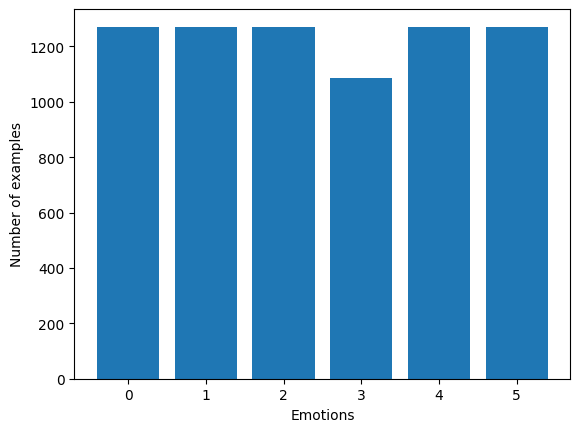

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=range(len(unique_emotions)), height=data['Emotions'].value_counts().loc[unique_emotions])
ax.set_xticks(ticks=range(len(unique_emotions)))
ax.set_xlabel('Emotions')
ax.set_ylabel('Number of examples')
plt.show()

In [5]:
signals = []
for i, file_path in enumerate(data.Path):
    audio, _ = librosa.load(file_path, duration=3, offset=0.5, sr=SAMPLE_RATE)
    signal = np.zeros((int(SAMPLE_RATE * 3,)))
    signal[:len(audio)] = audio
    signals.append(signal)
    print("\rProcessed {}/{} files".format(i + 1, len(data)), end='')

signals = np.stack(signals, axis=0)  # Convert list of arrays to a numpy array
print("\nShape of signals array:", signals.shape)

Processed 7442/7442 files
Shape of signals array: (7442, 48000)


In [6]:
EMOTIONS = {1: 'neutral', 2: 'happy', 3: 'sad', 4: 'angry', 5: 'fear', 0: 'disgust'}
emotion_to_int = {v: k for k, v in EMOTIONS.items()}
mel_spectrograms = []
X = signals
train_ind, test_ind, val_ind = [], [], []
X_train, X_val, X_test = [], [], []
Y_train, Y_val, Y_test = [], [], []

for emotion in EMOTIONS.values():
    emotion_ind = list(data.loc[data.Emotions == emotion, 'Emotions'].index)
    emotion_ind = np.random.permutation(emotion_ind).astype(int)  # Ensure indices are integers
    m = len(emotion_ind)
    ind_train = emotion_ind[:int(0.8 * m)]
    ind_val = emotion_ind[int(0.8 * m):int(0.9 * m)]
    ind_test = emotion_ind[int(0.9 * m):]
    
    # Ensure indices are within the bounds of the signals array
    ind_train = [i for i in ind_train if i < signals.shape[0]]
    ind_val = [i for i in ind_val if i < signals.shape[0]]
    ind_test = [i for i in ind_test if i < signals.shape[0]]
    
    if ind_train:
        X_train.append(signals[ind_train, :])
        Y_train.append(np.array([emotion_to_int[emotion]] * len(ind_train), dtype=np.int32))
    if ind_val:
        X_val.append(signals[ind_val, :])
        Y_val.append(np.array([emotion_to_int[emotion]] * len(ind_val), dtype=np.int32))
    if ind_test:
        X_test.append(signals[ind_test, :])
        Y_test.append(np.array([emotion_to_int[emotion]] * len(ind_test), dtype=np.int32))
    
    train_ind.append(ind_train)
    test_ind.append(ind_test)
    val_ind.append(ind_val)

X_train = np.concatenate(X_train, 0) if X_train else np.array([])
X_val = np.concatenate(X_val, 0) if X_val else np.array([])
X_test = np.concatenate(X_test, 0) if X_test else np.array([])
Y_train = np.concatenate(Y_train, 0) if Y_train else np.array([])
Y_val = np.concatenate(Y_val, 0) if Y_val else np.array([])
Y_test = np.concatenate(Y_test, 0) if Y_test else np.array([])
train_ind = np.concatenate(train_ind, 0) if train_ind else np.array([])
val_ind = np.concatenate(val_ind, 0) if val_ind else np.array([])
test_ind = np.concatenate(test_ind, 0) if test_ind else np.array([])

print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')
print(f'X_val: {X_val.shape}, Y_val: {Y_val.shape}')
print(f'X_test: {X_test.shape}, Y_test: {Y_test.shape}')

# Check if all are unique
unique, count = np.unique(np.concatenate([train_ind, test_ind, val_ind], 0), return_counts=True)
print("Number of unique indexes is {}, out of {}".format(sum(count == 1), signals.shape[0]))
del signals

X_train: (5949, 48000), Y_train: (5949,)
X_val: (744, 48000), Y_val: (744,)
X_test: (749, 48000), Y_test: (749,)
Number of unique indexes is 7442, out of 7442


In [7]:
def addAWGN(signal, num_bits=16, augmented_num=2, snr_low=15, snr_high=30): 
    signal_len = len(signal)
    # Generate White Gaussian noise
    noise = np.random.normal(size=(augmented_num, signal_len))
    # Normalize signal and noise
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    # Compute signal and noise power
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high)
    # Compute K (covariance matrix) for each noise 
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K  
    # Generate noisy signal
    return signal + K.T * noise

In [8]:
aug_signals = []
aug_labels = []
new_data_rows = []

for i in range(X_train.shape[0]):
    signal = X_train[i, :]
    augmented_signal = addAWGN(signal)
    
    if augmented_signal.shape != signal.shape:
        augmented_signal = augmented_signal[0, :]  

    aug_labels.append(Y_train[i]) 
    aug_signals.append(augmented_signal)
    
    new_row = data.iloc[i].copy()
    new_data_rows.append(new_row)
    
    print("\r Processed {}/{} files".format(i + 1, X_train.shape[0]), end='')

aug_signals = np.stack(aug_signals, axis=0)

#print(f"aug_signals shape: {aug_signals.shape}")

X_train = np.concatenate([X_train, aug_signals], axis=0)
aug_labels = np.array(aug_labels)
Y_train = np.concatenate([Y_train, aug_labels])

new_data_df = pd.DataFrame(new_data_rows)
data = pd.concat([data, new_data_df], ignore_index=True)

print('')
print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')


 Processed 5949/5949 files
X_train: (11898, 48000), Y_train: (11898,)


In [9]:
print(f"signal shape: {signal.shape}")
print(f"augmented_signal shape: {augmented_signal.shape}")
print(f"aug_signals shape: {aug_signals.shape}")
print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')

signal shape: (48000,)
augmented_signal shape: (48000,)
aug_signals shape: (5949, 48000)
X_train: (11898, 48000), Y_train: (11898,)


MEL spectrogram shape:  (128, 188)


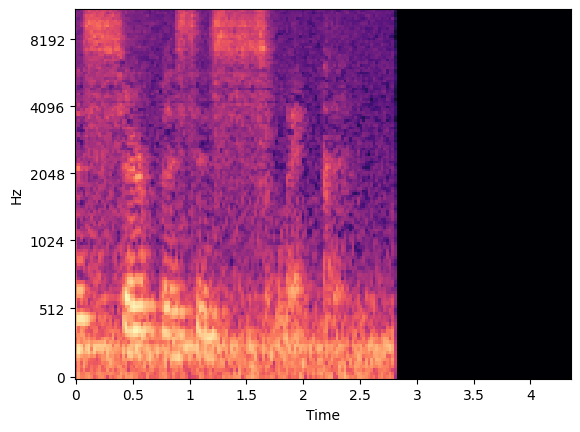

In [10]:
def getMELspectrogram(audio, sample_rate):
    mel_spec = librosa.feature.melspectrogram(y=audio,
                                              sr=sample_rate,
                                              n_fft=1024,
                                              win_length = 512,
                                              window='hamming',
                                              hop_length = 256,
                                              n_mels=128,
                                              fmax=sample_rate/2
                                             )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# test function
audio, sample_rate = librosa.load(data.loc[0,'Path'], duration=3, offset=0.5,sr=SAMPLE_RATE)
signal = np.zeros((int(SAMPLE_RATE*3,)))
signal[:len(audio)] = audio
mel_spectrogram = getMELspectrogram(signal, SAMPLE_RATE)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
print('MEL spectrogram shape: ',mel_spectrogram.shape)

In [11]:
mel_train = []
print("Calculatin mel spectrograms for train set")
for i in range(X_train.shape[0]):
    mel_spectrogram = getMELspectrogram(X_train[i,:], sample_rate=SAMPLE_RATE)
    mel_train.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_train.shape[0]),end='')
print('')
mel_train = np.stack(mel_train,axis=0)
del X_train
X_train = mel_train

mel_val = []
print("Calculatin mel spectrograms for val set")
for i in range(X_val.shape[0]):
    mel_spectrogram = getMELspectrogram(X_val[i,:], sample_rate=SAMPLE_RATE)
    mel_val.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_val.shape[0]),end='')
print('')
mel_val = np.stack(mel_val,axis=0)
del X_val
X_val = mel_val

mel_test = []
print("Calculatin mel spectrograms for test set")
for i in range(X_test.shape[0]):
    mel_spectrogram = getMELspectrogram(X_test[i,:], sample_rate=SAMPLE_RATE)
    mel_test.append(mel_spectrogram)
    print("\r Processed {}/{} files".format(i,X_test.shape[0]),end='')
print('')
mel_test = np.stack(mel_test,axis=0)
del X_test
X_test = mel_test

print(f'X_train:{X_train.shape}, Y_train:{Y_train.shape}')
print(f'X_val:{X_val.shape}, Y_val:{Y_val.shape}')
print(f'X_test:{X_test.shape}, Y_test:{Y_test.shape}')

Calculatin mel spectrograms for train set
 Processed 11897/11898 files
Calculatin mel spectrograms for val set
 Processed 743/744 files
Calculatin mel spectrograms for test set
 Processed 748/749 files
X_train:(11898, 128, 188), Y_train:(11898,)
X_val:(744, 128, 188), Y_val:(744,)
X_test:(749, 128, 188), Y_test:(749,)


In [12]:
import torch
import torch.nn as nn

class ParallelModel(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        # conv block
        self.conv2Dblock = nn.Sequential(
            # 1. conv block
            nn.Conv2d(in_channels=1,
                       out_channels=16,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.3),
            # 2. conv block
            nn.Conv2d(in_channels=16,
                       out_channels=32,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 3. conv block
            nn.Conv2d(in_channels=32,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3),
            # 4. conv block
            nn.Conv2d(in_channels=64,
                       out_channels=64,
                       kernel_size=3,
                       stride=1,
                       padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.3)
        )
        # LSTM block
        self.lstm_maxpool = nn.MaxPool2d(kernel_size=[2,4], stride=[2,4])
        hidden_size = 128
        self.lstm = nn.LSTM(input_size=64,hidden_size=hidden_size,bidirectional=True, batch_first=True)
        self.dropout_lstm = nn.Dropout(0.1)
        self.attention_linear = nn.Linear(2*hidden_size,1) # 2*hidden_size for the 2 outputs of bidir LSTM
        
        #Change in architecture 
        conv_output_size = 64  # This should match the flattened output size of your conv layers
        lstm_output_size = 2 * hidden_size  # For bidirectional LSTM
        total_embedding_size = conv_output_size + lstm_output_size

        
        # Linear softmax layer
        self.out_linear = nn.Linear(total_embedding_size, num_emotions)
        self.dropout_linear = nn.Dropout(p=0)
        self.out_softmax = nn.Softmax(dim=1)
        
        
    def forward(self,x):
        # conv embedding
        conv_embedding = self.conv2Dblock(x) #(b,channel,freq,time)
        conv_embedding = torch.flatten(conv_embedding, start_dim=1)
        #print("Conv embedding shape:", conv_embedding.shape)
       
        # lstm embedding
        x_reduced = self.lstm_maxpool(x)
        x_reduced = torch.squeeze(x_reduced,1)
        x_reduced = x_reduced.permute(0,2,1) # (b,t,freq)
        lstm_embedding, (h,c) = self.lstm(x_reduced) # (b, time, hidden_size*2)
        lstm_embedding = self.dropout_lstm(lstm_embedding)
        batch_size,T,_ = lstm_embedding.shape 
        attention_weights = [None]*T
        for t in range(T):
            embedding = lstm_embedding[:,t,:]
            attention_weights[t] = self.attention_linear(embedding)
        attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights,-1),-1)
        attention = torch.bmm(attention_weights_norm,lstm_embedding) # (Bx1xT)*(B,T,hidden_size*2)=(B,1,2*hidden_size)
        attention = torch.squeeze(attention, 1)
        #print("Attention shape:", attention.shape)
        
        # concatenate
        complete_embedding = torch.cat([conv_embedding, attention], dim=1) 
        #print("Complete embedding shape:", complete_embedding.shape)
        output_logits = self.out_linear(complete_embedding)
        output_logits = self.dropout_linear(output_logits)
        output_softmax = self.out_softmax(output_logits)
        return output_logits, output_softmax, attention_weights_norm
                                     

In [13]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss()(input=predictions,target=targets)

In [14]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits, output_softmax, attention_weights_norm = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100
    return train_step

In [15]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
            output_logits, output_softmax, attention_weights_norm = model(X)
            predictions = torch.argmax(output_softmax,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions
    return validate

In [16]:
from sklearn.preprocessing import StandardScaler

X_train = np.expand_dims(X_train,1)
X_val = np.expand_dims(X_val,1)
X_test = np.expand_dims(X_test,1)

scaler = StandardScaler()

b,c,h,w = X_train.shape
X_train = np.reshape(X_train, newshape=(b,-1))
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, newshape=(b,c,h,w))

b,c,h,w = X_test.shape
X_test = np.reshape(X_test, newshape=(b,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, newshape=(b,c,h,w))

b,c,h,w = X_val.shape
X_val = np.reshape(X_val, newshape=(b,-1))
X_val = scaler.transform(X_val)
X_val = np.reshape(X_val, newshape=(b,c,h,w))

In [17]:
EPOCHS=100
DATASET_SIZE = X_train.shape[0]
BATCH_SIZE = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
model = ParallelModel(num_emotions=len(EMOTIONS)).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
OPTIMIZER = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)
losses=[]
val_losses = []
for epoch in range(EPOCHS):
    # schuffle data
    ind = np.random.permutation(DATASET_SIZE)
    X_train = X_train[ind,:,:,:]
    Y_train = Y_train[ind]
    epoch_acc = 0
    epoch_loss = 0
    iters = int(DATASET_SIZE / BATCH_SIZE)
    for i in range(iters):
        batch_start = i * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, DATASET_SIZE)
        actual_batch_size = batch_end-batch_start
        X = X_train[batch_start:batch_end,:,:,:]
        Y = Y_train[batch_start:batch_end]
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc = train_step(X_tensor,Y_tensor)
        epoch_acc += acc*actual_batch_size/DATASET_SIZE
        epoch_loss += loss*actual_batch_size/DATASET_SIZE
        print(f"\r Epoch {epoch}: iteration {i}/{iters}",end='')
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, _ = validate(X_val_tensor,Y_val_tensor)
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    print('')
    print(f"Epoch {epoch} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%")
    

Selected device is cuda
Number of trainable params:  261415
 Epoch 0: iteration 370/371
Epoch 0 --> loss:1.6239, acc:31.91%, val_loss:2.0052, val_acc:20.43%
 Epoch 1: iteration 370/371
Epoch 1 --> loss:1.4870, acc:38.29%, val_loss:1.7809, val_acc:28.09%
 Epoch 2: iteration 370/371
Epoch 2 --> loss:1.4343, acc:41.45%, val_loss:1.8216, val_acc:28.63%
 Epoch 3: iteration 370/371
Epoch 3 --> loss:1.3927, acc:43.88%, val_loss:1.6095, val_acc:33.74%
 Epoch 4: iteration 370/371
Epoch 4 --> loss:1.3645, acc:44.85%, val_loss:1.5138, val_acc:38.71%
 Epoch 5: iteration 370/371
Epoch 5 --> loss:1.3245, acc:46.93%, val_loss:1.5306, val_acc:39.38%
 Epoch 6: iteration 370/371
Epoch 6 --> loss:1.2917, acc:48.38%, val_loss:1.5307, val_acc:36.56%
 Epoch 7: iteration 370/371
Epoch 7 --> loss:1.2666, acc:49.66%, val_loss:1.4412, val_acc:42.61%
 Epoch 8: iteration 370/371
Epoch 8 --> loss:1.2378, acc:51.09%, val_loss:1.3963, val_acc:43.41%
 Epoch 9: iteration 370/371
Epoch 9 --> loss:1.2175, acc:51.67%, va

In [18]:
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'cnn_lstm_parallel_model.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'cnn_lstm_parallel_model.pt')))

Model is saved to /kaggle/working/models/cnn_lstm_parallel_model.pt


In [19]:
import sklearn.metrics as metrics

X_test_tensor = torch.tensor(X_test, device=device).float()
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long, device=device)
test_loss, test_acc, predictions = validate(X_test_tensor, Y_test_tensor)

if isinstance(predictions, torch.Tensor):
    predictions = predictions.cpu().numpy()

true_labels = Y_test_tensor.cpu().numpy()

recall = metrics.recall_score(true_labels, predictions, average='weighted')
f1 = metrics.f1_score(true_labels, predictions, average='weighted')

print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')
print(f'Test recall is {recall:.2f}')
print(f'Test F1 score is {f1:.2f}')


Test loss is 1.475
Test accuracy is 58.08%
Test recall is 0.58
Test F1 score is 0.58


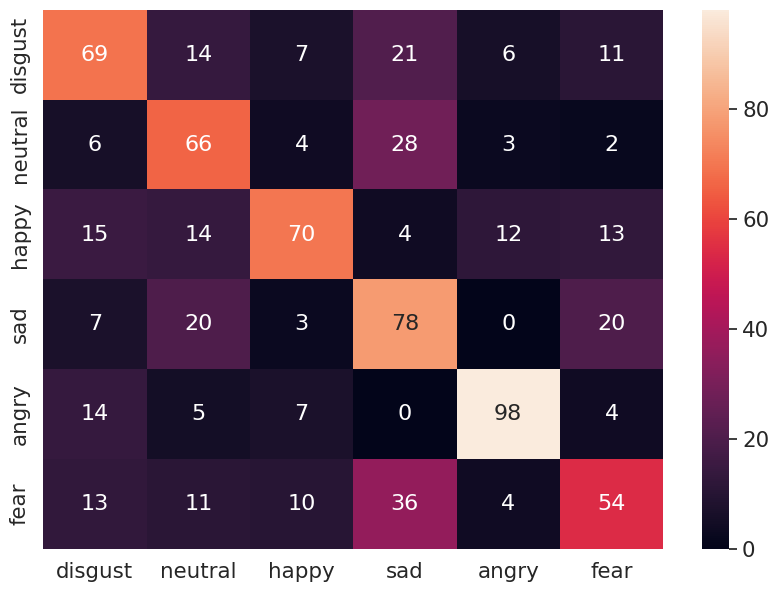

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_test, predictions)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)

plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.show()

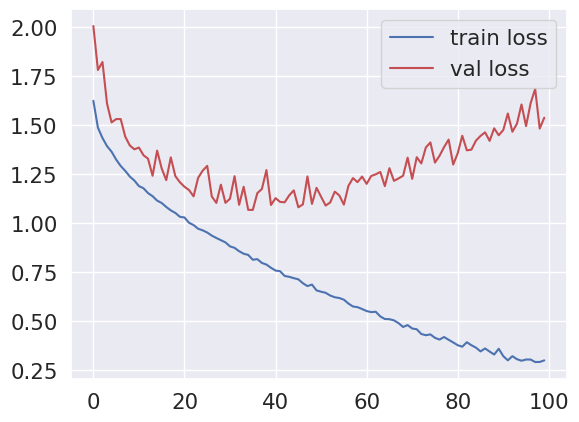

In [22]:
plt.plot(losses,'b')
plt.plot(val_losses,'r')
plt.legend(['train loss','val loss'])

In [23]:
!pip install torchinfo

In [25]:
from torchinfo import summary
input_size = (32, 1, 128, 188)  
summary(model, input_size=input_size, device='cuda') 

Layer (type:depth-idx)                   Output Shape              Param #
ParallelModel                            [32, 6]                   --
├─Sequential: 1-1                        [32, 64, 1, 1]            --
│    └─Conv2d: 2-1                       [32, 16, 128, 188]        160
│    └─BatchNorm2d: 2-2                  [32, 16, 128, 188]        32
│    └─ReLU: 2-3                         [32, 16, 128, 188]        --
│    └─MaxPool2d: 2-4                    [32, 16, 64, 94]          --
│    └─Dropout: 2-5                      [32, 16, 64, 94]          --
│    └─Conv2d: 2-6                       [32, 32, 64, 94]          4,640
│    └─BatchNorm2d: 2-7                  [32, 32, 64, 94]          64
│    └─ReLU: 2-8                         [32, 32, 64, 94]          --
│    └─MaxPool2d: 2-9                    [32, 32, 16, 23]          --
│    └─Dropout: 2-10                     [32, 32, 16, 23]          --
│    └─Conv2d: 2-11                      [32, 64, 16, 23]          18,496
│    └─